# 主成分分析による教師なし次元削減

## 共分散行列の固有対を求める

In [1]:
import pandas as pd

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header = None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']

In [4]:
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.fit_transform(X_test)

In [5]:
import numpy as np

cov_mat = np.cov(X_train_std.T)
# np.linalg.eig(X): Xの固有値と固有ベクトルを返す
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
print('\nEigenvalues \n%s' % eigen_vals)


Eigenvalues 
[ 4.8923083   2.46635032  1.42809973  1.01233462  0.84906459  0.60181514
  0.52251546  0.08414846  0.33051429  0.29595018  0.16831254  0.21432212
  0.2399553 ]


 ## 固有値$\lambda_j$の分散説明率

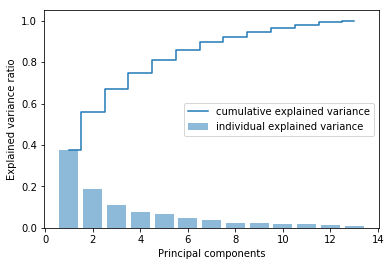

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse = True)]
cum_var_exp = np.cumsum(var_exp)
plt.bar(range(1, 14), var_exp, alpha = 0.5, align = 'center', label = 'individual explained variance')
plt.step(range(1, 14), cum_var_exp, where = 'mid', label = 'cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc = 'best')
plt.show()

## 特徴変換

In [13]:
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]
eigen_pairs.sort(key = lambda k: k[0], reverse = True)
w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))
print('Matrix w:\n', w)

Matrix w:
 [[ 0.14669811  0.50417079]
 [-0.24224554  0.24216889]
 [-0.02993442  0.28698484]
 [-0.25519002 -0.06468718]
 [ 0.12079772  0.22995385]
 [ 0.38934455  0.09363991]
 [ 0.42326486  0.01088622]
 [-0.30634956  0.01870216]
 [ 0.30572219  0.03040352]
 [-0.09869191  0.54527081]
 [ 0.30032535 -0.27924322]
 [ 0.36821154 -0.174365  ]
 [ 0.29259713  0.36315461]]


In [15]:
X_train_pca = X_train_std.dot(w)

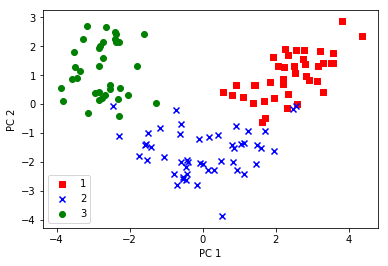

In [18]:
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train == l, 0 ], X_train_pca[y_train == l, 1], c = c, label = l, marker = m)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc = 'lower left')
plt.show()

## scikit-learnの主成分分析

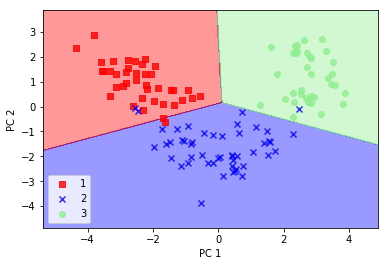

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
import pdr

pca = PCA(n_components = 2)
lr = LogisticRegression()

X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.fit_transform(X_test_std)

lr.fit(- X_train_pca, y_train)

pdr.plot_decision_regions(- X_train_pca, y_train, classifier = lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc = 'lower left')
plt.show()

### 変換後のテストデータセットに対するロジスティック回帰の決定領域

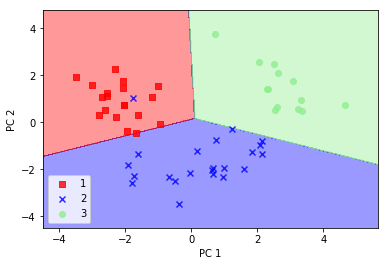

In [29]:
pdr.plot_decision_regions(X_test_pca, y_test, classifier = lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc = 'lower left')
plt.show()

全ての主成分の分散説明率に関心がある場合

In [22]:
pca = PCA(n_components = None)
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([ 0.37329648,  0.18818926,  0.10896791,  0.07724389,  0.06478595,
        0.04592014,  0.03986936,  0.02521914,  0.02258181,  0.01830924,
        0.01635336,  0.01284271,  0.00642076])

## 線形判別分析（LDA）

In [30]:
np.set_printoptions(precision = 4)
mean_vecs = []
for label in range(1, 4):
    mean_vecs.append(np.mean(X_train_std[y_train == label], axis = 0))
    print('MV %s: %s\n' %(label, mean_vecs[label - 1]))

MV 1: [ 0.9259 -0.3091  0.2592 -0.7989  0.3039  0.9608  1.0515 -0.6306  0.5354
  0.2209  0.4855  0.798   1.2017]

MV 2: [-0.8727 -0.3854 -0.4437  0.2481 -0.2409 -0.1059  0.0187 -0.0164  0.1095
 -0.8796  0.4392  0.2776 -0.7016]

MV 3: [ 0.1637  0.8929  0.3249  0.5658 -0.01   -0.9499 -1.228   0.7436 -0.7652
  0.979  -1.1698 -1.3007 -0.3912]



In [31]:
d = 13
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.zeros((d, d))
    for row in X_train_std[y_train == label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)
        class_scatter += (row - mv).dot((row - mv).T)
    S_W += class_scatter

print('Within-class scatter matrix: %sx%s' % (S_W.shape[0], S_W.shape[1]))

Within-class scatter matrix: 13x13


### 変動行列を計算するときには，トレーニングデータセットにおいてクラスラベルが一様分布していることが前提

In [32]:
print('Class label distribution: %s' % np.bincount(y_train)[1:])

Class label distribution: [40 49 35]


### $S_W$を生成する前にスケーリングが必要

In [34]:
d = 13
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train == label].T)
    S_W += class_scatter
    
print('Scaled within-class scatter matrix: %sx%s' % (S_W.shape[0], S_W.shape[1]))

Scaled within-class scatter matrix: 13x13


### クラス間変動行列$S_B$

In [39]:
mean_overall = np.mean(X_train_std, axis = 0)
d = 13
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    # ラベル1のトレーニングサンプル数
    n = X_train_std[y_train == i+1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)
    mean_overall = mean_overall.reshape(d, 1)
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)
    
print('Between-class scatter matrix: %sx%s' % (S_B.shape[0], S_B.shape[1]))

Between-class scatter matrix: 13x13


### 新しい特徴部分空間の線形判別を選択

In [40]:
# inv関数で逆行列，dot関数で行列積，eig関数で固有値
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

In [41]:
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]
eigen_pairs = sorted(eigen_pairs, key = lambda k: k[0], reverse = True)
print('Eigenvalues in decreasing order:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigenvalues in decreasing order:

452.721581245
156.43636122
1.05646703435e-13
3.99641853702e-14
3.40923565291e-14
2.84217094304e-14
1.4793035293e-14
1.4793035293e-14
1.3494134504e-14
1.3494134504e-14
6.49105985585e-15
6.49105985585e-15
2.65581215704e-15


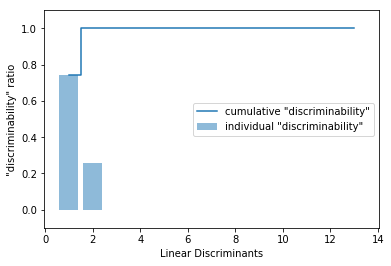

In [42]:
tot = sum(eigen_vals.real)
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse = True)]
cum_discr = np.cumsum(discr)
plt.bar(range(1, 14), discr, alpha = 0.5, align = 'center', label = 'individual "discriminability"')
plt.step(range(1, 14), cum_discr, where = 'mid', label = 'cumulative "discriminability"')
plt.ylabel('"discriminability" ratio')
plt.xlabel('Linear Discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc = 'best')
plt.show()

In [43]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real, eigen_pairs[1][1][:, np.newaxis].real))
print('Matrix W:\n', w)

Matrix W:
 [[-0.0662 -0.3797]
 [ 0.0386 -0.2206]
 [-0.0217 -0.3816]
 [ 0.184   0.3018]
 [-0.0034  0.0141]
 [ 0.2326  0.0234]
 [-0.7747  0.1869]
 [-0.0811  0.0696]
 [ 0.0875  0.1796]
 [ 0.185  -0.284 ]
 [-0.066   0.2349]
 [-0.3805  0.073 ]
 [-0.3285 -0.5971]]


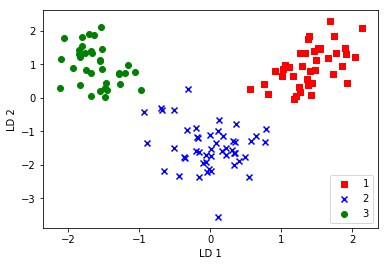

In [44]:
X_train_lda = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train == l, 0 ] * -1, X_train_lda[y_train == l, 1] * -1, c = c, label = l, marker = m)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc = 'lower right')
plt.show()

## scikit-learnによるLDA

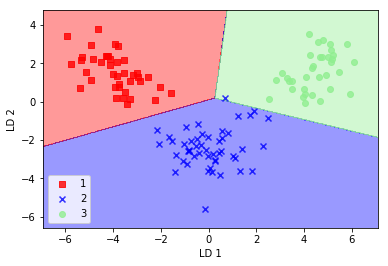

In [9]:
from sklearn.lda import LDA
from sklearn.linear_model import LogisticRegression
import pdr

lda = LDA(n_components = 2)
X_train_lda = lda.fit_transform(X_train_std, y_train)
lr = LogisticRegression()
lr = lr.fit(X_train_lda, y_train)

pdr.plot_decision_regions(X_train_lda, y_train, classifier = lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc = 'lower left')
plt.show()

テストデータでの結果

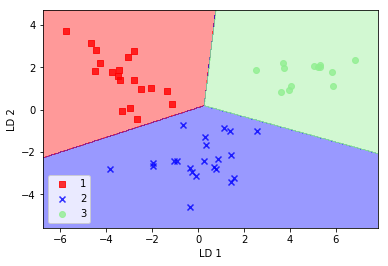

In [10]:
X_test_lda = lda.transform(X_test_std)

pdr.plot_decision_regions(X_test_lda, y_test, classifier = lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc = 'lower left')
plt.show()

## カーネル主成分分析を使った非線形写像

半月型データセット

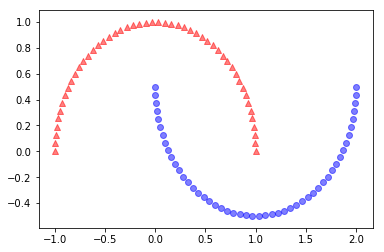

In [20]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples = 100, random_state = 123)
plt.scatter(X[y == 0, 0], X[y == 0, 1], color = 'red', marker = '^', alpha = 0.5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color = 'blue', marker = 'o', alpha = 0.5)
plt.show()

標準のPCAを使った場合

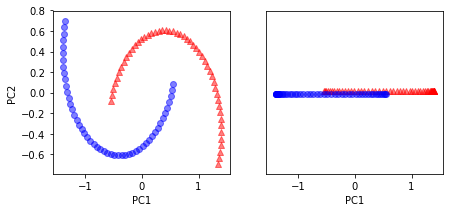

In [21]:
from sklearn.decomposition import PCA

scikit_pca = PCA(n_components = 2)
X_spca = scikit_pca.fit_transform(X)
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (7, 3))
ax[0].scatter(X_spca[y == 0, 0], X_spca[y ==0, 1], color = 'red', marker = '^', alpha = 0.5)
ax[0].scatter(X_spca[y == 1, 0], X_spca[y == 1, 1], color = 'blue', marker = 'o', alpha = 0.5)

ax[1].scatter(X_spca[y == 0, 0], np.zeros((50, 1)) + 0.02, color = 'red', marker = '^', alpha = 0.5)
ax[1].scatter(X_spca[y == 1, 0], np.zeros((50, 1)) - 0.02, color = 'blue', marker = 'o', alpha = 0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')

ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')
plt.show()

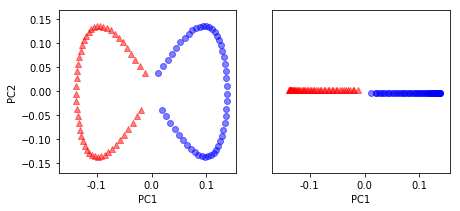

In [22]:
from matplotlib.ticker import FormatStrFormatter
import k_pca_origin

X_kpca = k_pca_origin.rbf_kernel_pca(X, gamma = 15, n_components = 2)
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (7, 3))

ax[0].scatter(X_kpca[y == 0, 0], X_kpca[y ==0, 1], color = 'red', marker = '^', alpha = 0.5)
ax[0].scatter(X_kpca[y == 1, 0], X_kpca[y == 1, 1], color = 'blue', marker = 'o', alpha = 0.5)

ax[1].scatter(X_kpca[y == 0, 0], np.zeros((50, 1)) + 0.02, color = 'red', marker = '^', alpha = 0.5)
ax[1].scatter(X_kpca[y == 1, 0], np.zeros((50, 1)) - 0.02, color = 'blue', marker = 'o', alpha = 0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')

ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

ax[0].xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
ax[1].xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
plt.show()

同心円の分離

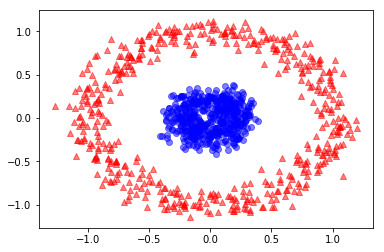

In [23]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples = 1000, random_state = 123, noise = 0.1, factor = 0.2)
plt.scatter(X[y == 0, 0], X[y == 0, 1], color = 'red', marker = '^', alpha = 0.5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color = 'blue', marker = 'o', alpha = 0.5)
plt.show()

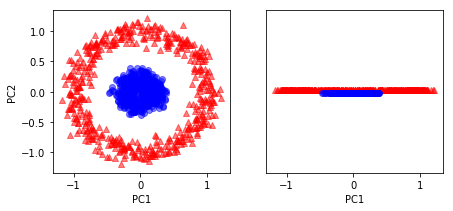

In [24]:
scikit_pca = PCA(n_components = 2)
X_spca = scikit_pca.fit_transform(X)
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (7, 3))
ax[0].scatter(X_spca[y == 0, 0], X_spca[y ==0, 1], color = 'red', marker = '^', alpha = 0.5)
ax[0].scatter(X_spca[y == 1, 0], X_spca[y == 1, 1], color = 'blue', marker = 'o', alpha = 0.5)

ax[1].scatter(X_spca[y == 0, 0], np.zeros((500, 1)) + 0.02, color = 'red', marker = '^', alpha = 0.5)
ax[1].scatter(X_spca[y == 1, 0], np.zeros((500, 1)) - 0.02, color = 'blue', marker = 'o', alpha = 0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')

ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')
plt.show()

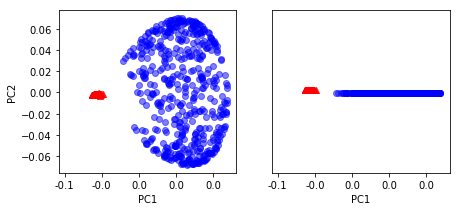

In [25]:
X_kpca = k_pca_origin.rbf_kernel_pca(X, gamma = 15, n_components = 2)
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (7, 3))

ax[0].scatter(X_kpca[y == 0, 0], X_kpca[y ==0, 1], color = 'red', marker = '^', alpha = 0.5)
ax[0].scatter(X_kpca[y == 1, 0], X_kpca[y == 1, 1], color = 'blue', marker = 'o', alpha = 0.5)

ax[1].scatter(X_kpca[y == 0, 0], np.zeros((500, 1)) + 0.02, color = 'red', marker = '^', alpha = 0.5)
ax[1].scatter(X_kpca[y == 1, 0], np.zeros((500, 1)) - 0.02, color = 'blue', marker = 'o', alpha = 0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')

ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

ax[0].xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
ax[1].xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
plt.show()

新しい半月型データセットの作成

In [10]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples = 100, random_state = 123)
alphas, lambdas = k_pca.rbf_kernel_pca(X, gamma = 15, n_components = 1)

In [12]:
import k_pca

x_new = X[25]
print(x_new)
x_proj = alphas[25]
print(x_proj)

def project_x(x_new, X, gamma, alphas, lambdas):
    pair_dist = np.array([np.sum((x_new - row)**2) for row in X])
    k = np.exp(-gamma * pair_dist)
    return k.dot(alphas / lambdas)

[ 1.8713187   0.00928245]
[ 0.07877284]


In [14]:
x_reproj = project_x(x_new, X, gamma = 15, alphas = alphas, lambdas = lambdas)
x_reproj

array([ 0.07877284])

最初の主成分への射影をプロット

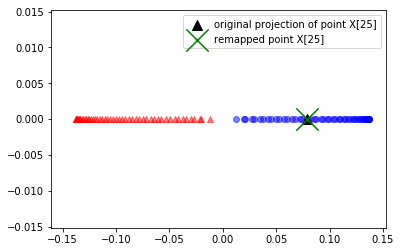

In [17]:
plt.scatter(alphas[y == 0, 0], np.zeros((50)), color = 'red', marker = '^', alpha = 0.5)
plt.scatter(alphas[y == 1, 0], np.zeros((50)), color = 'blue', marker = 'o', alpha = 0.5)
plt.scatter(x_proj, 0, color = 'black', label = 'original projection of point X[25]', marker = '^', s = 100)
plt.scatter(x_reproj, 0, color = 'green', label = 'remapped point X[25]', marker = 'x', s = 500)
plt.legend(scatterpoints = 1)
plt.show()

### scikit-learnのカーネル主成分分析

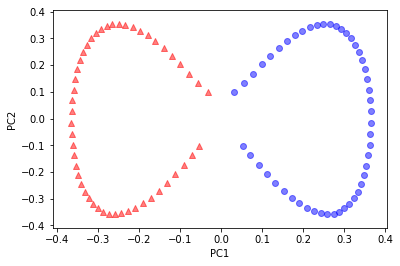

In [19]:
from sklearn.decomposition import KernelPCA

X, y = make_moons(n_samples = 100, random_state = 123)
scikit_kpca = KernelPCA(n_components = 2, kernel = 'rbf', gamma = 15)
X_skernpca = scikit_kpca.fit_transform(X)

plt.scatter(X_skernpca[y == 0, 0], X_skernpca[y == 0, 1], color = 'red', marker = '^', alpha = 0.5)
plt.scatter(X_skernpca[y == 1, 0], X_skernpca[y == 1, 1], color = 'blue', marker = 'o', alpha = 0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()